***Умова:***

1. Створіть xls-документ, що містить дані про міста, їх населення, середній дохід жителів, площу території та наявність метрополітену.
   Кількість записів у документі - 20.
3. За допомогою Plotly візуалізуйте залежності населення міста від його площі та середнього доходу від населення. Помістіть ці графіки на один малюнок.
4. Побудуйте мтрицю кореляцій та візуалізуйте її через heatmep.
5. Побудуйте звіти про таблицю за допомогою Sweetviz та Pandas Profiling; напишіть коротке порівняння цих звітів.

**1. Отримання даних із xls таблиці**

In [11]:
import pandas as pd
import plotly
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import sweetviz as sv
import ydata_profiling as yp

df = pd.read_excel("cities.xlsx")
df

,city,inhabitans,income,square,metro
0,Kyiv,2567000,17053,836,True
1,Lviv,725000,12530,160,False
2,Dnipro,1053000,14099,380,True
3,Kharkiv,1450000,12175,350,True
4,Ivano-Frankivsk,215000,12228,83,False
5,Ternopil,226000,11720,59,False
6,Vinnicya,354000,12533,114,False
7,Zaporizga,772000,13889,240,False
8,Luck,205000,11492,42,False
9,Odesa,1010000,12519,163,False


**2. Візуалізація злежностей за допомогою Plotly**

In [12]:

df = df.sort_values(by='inhabitans')
fig = make_subplots(rows=2, cols=1)
fig.add_scatter(x=df['inhabitans'],  y=df['square'], mode='lines', row=1, col=1, name = "dependence inhabitans / square")
fig.add_scatter(x=df['inhabitans'],  y=df['income'], mode='lines', row=2, col=1, name = "dependence inhabitans / income")
fig.update_xaxes(title_text="inhabitans", row=1, col=1)
fig.update_yaxes(title_text = "square", row = 1, col = 1)
fig.update_xaxes(title_text="inhabitans", row=2, col=1)
fig.update_yaxes(title_text = "income", row = 2, col = 1)
fig.show()



**3. Візуалізація матриці кореляцій**

In [13]:
df_cor = df.corr(numeric_only = True)
fig = go.Figure()
fig.add_trace(go.Heatmap(x=df_cor.columns, y=df_cor.index, z=df_cor, colorscale='Greys'))
fig.layout.autosize = True
fig.layout.height = 600
fig.layout.width = 600

fig.show()









**4.1 Створення звіту до таблиці за допомогою Sweetviz.**

C:\Users\админ\PycharmProjects\Lesson_6\venv\lib\site-packages\sweetviz\dataframe_report.py:74: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\админ\PycharmProjects\Lesson_6\venv\lib\site-packages\sweetviz\dataframe_report.py:109: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



                                             |                                                                …

C:\Users\админ\PycharmProjects\Lesson_6\venv\lib\site-packages\sweetviz\series_analyzer_text.py:19: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\админ\PycharmProjects\Lesson_6\venv\lib\site-packages\sweetviz\series_analyzer_numeric.py:25: FutureWarning:

The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.

C:\Users\админ\PycharmProjects\Lesson_6\venv\lib\site-packages\sweetviz\series_analyzer_numeric.py:25: FutureWarning:

The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.

C:\Users\админ\PycharmProjects\Lesson_6\venv\lib\site-packages\sweetviz\series_analyzer_numeric.py:25: FutureWarning:

The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.

C:\Use


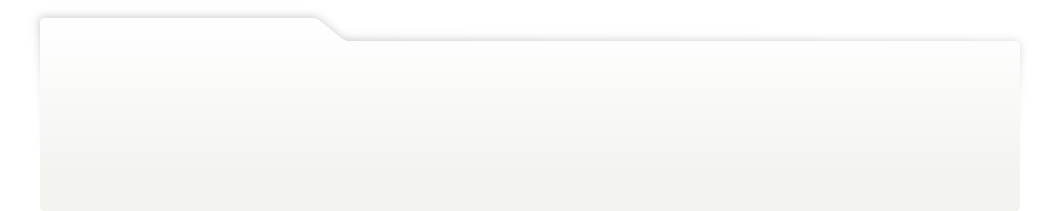
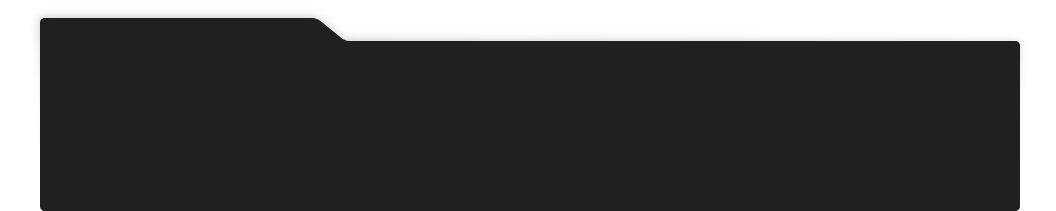
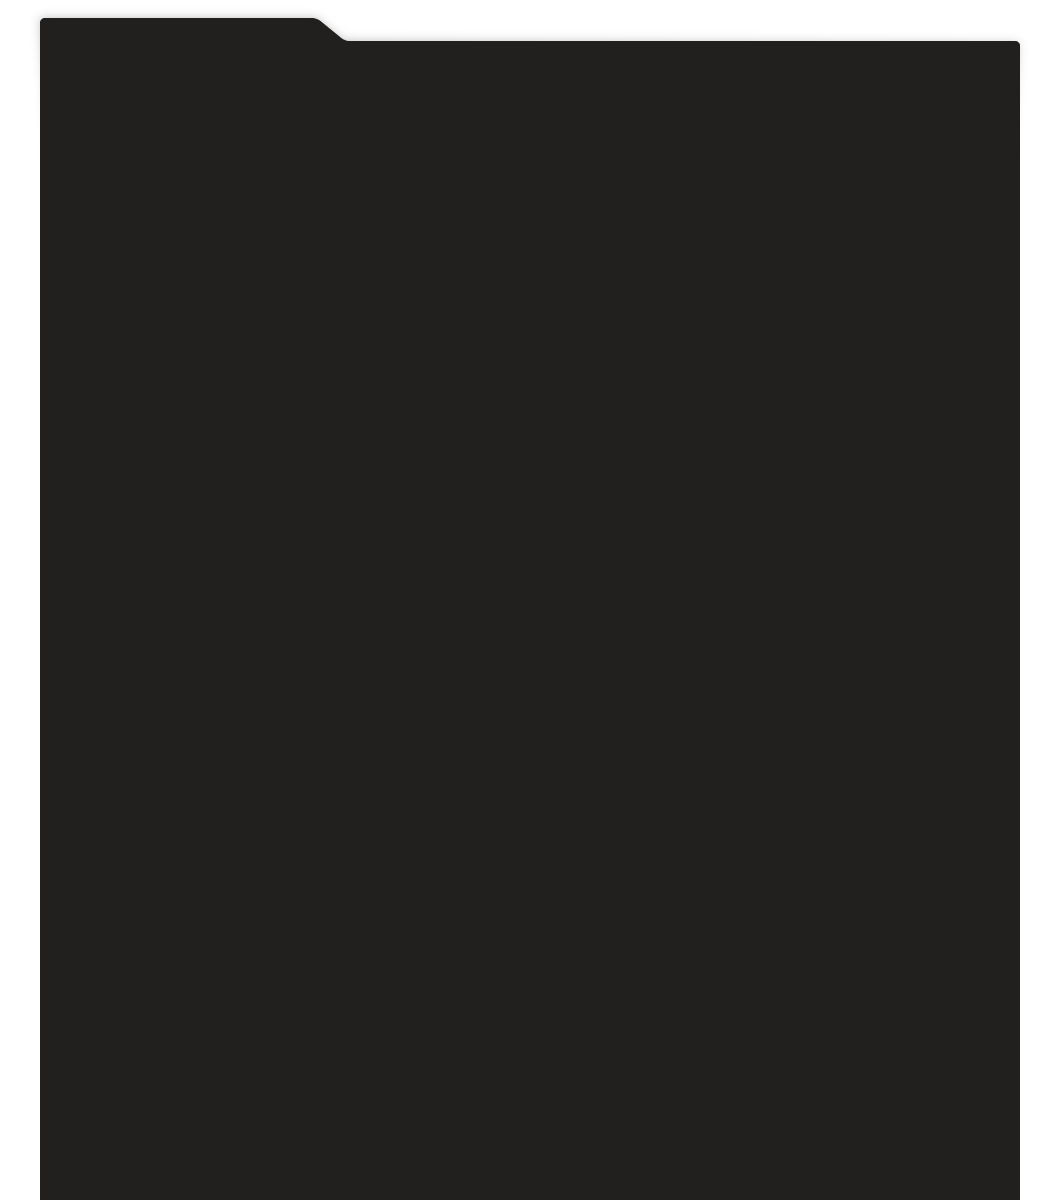
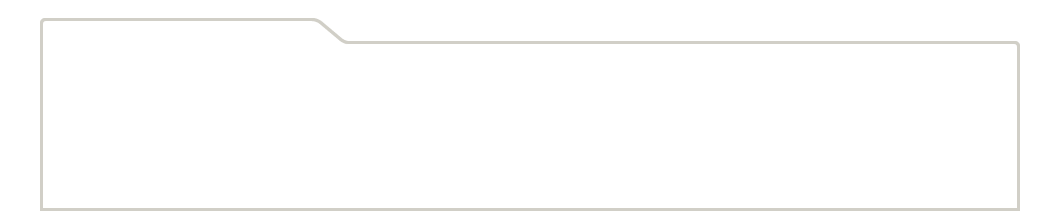
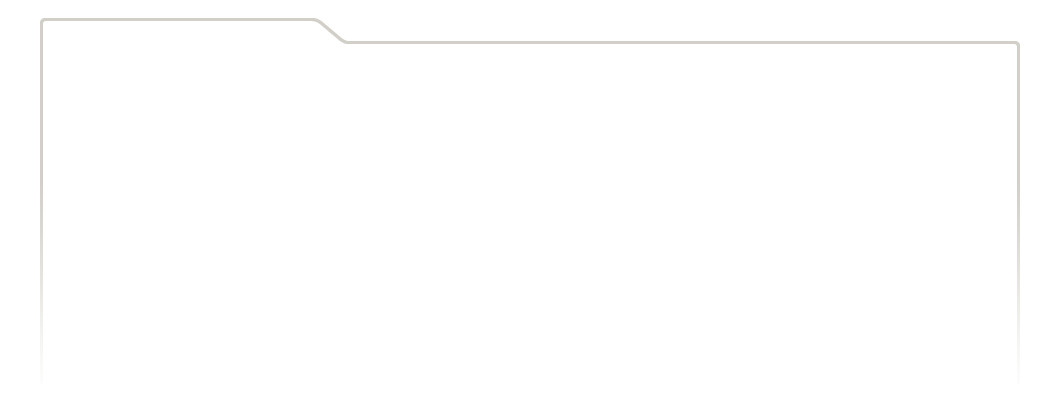
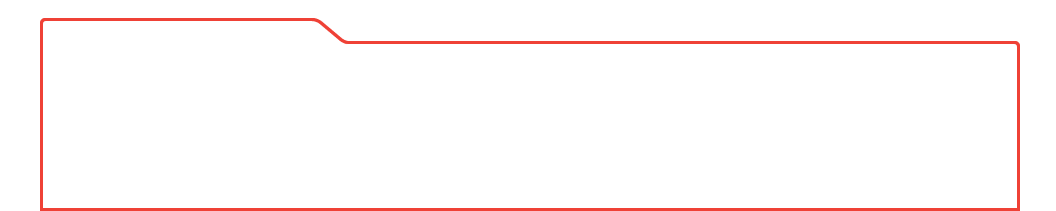
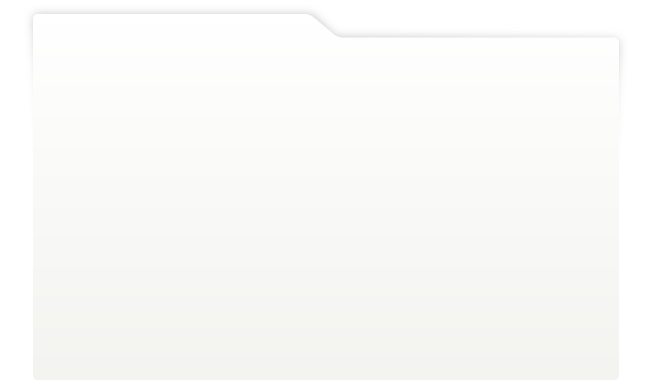
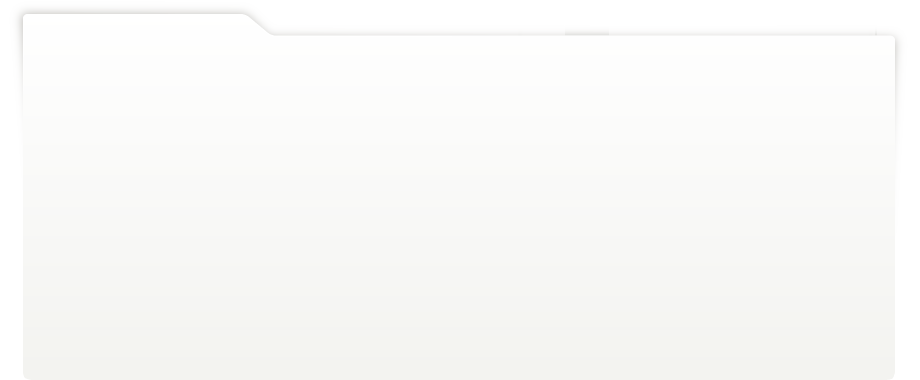
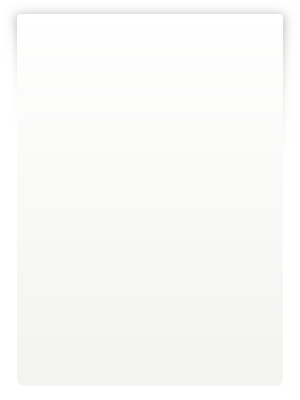
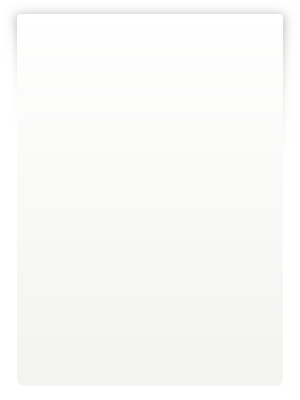
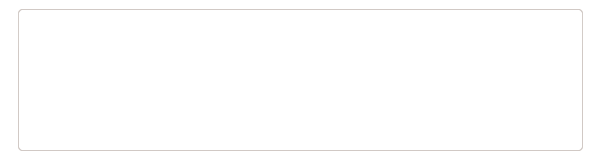
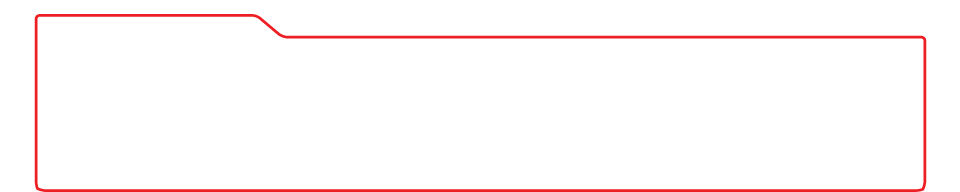
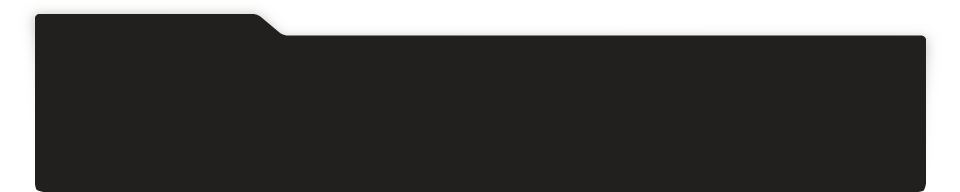
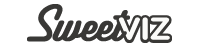
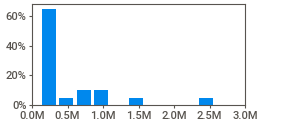
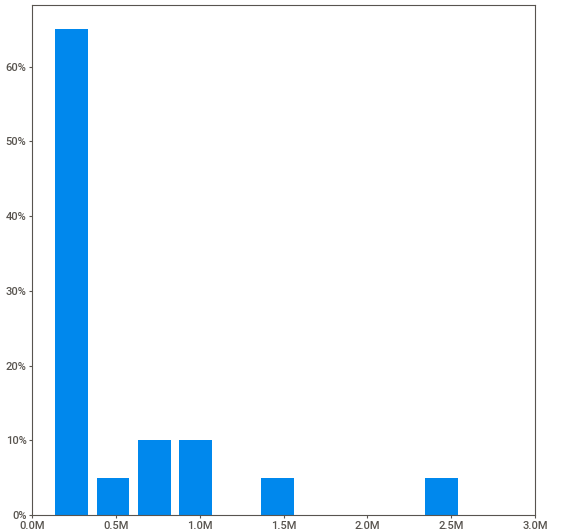
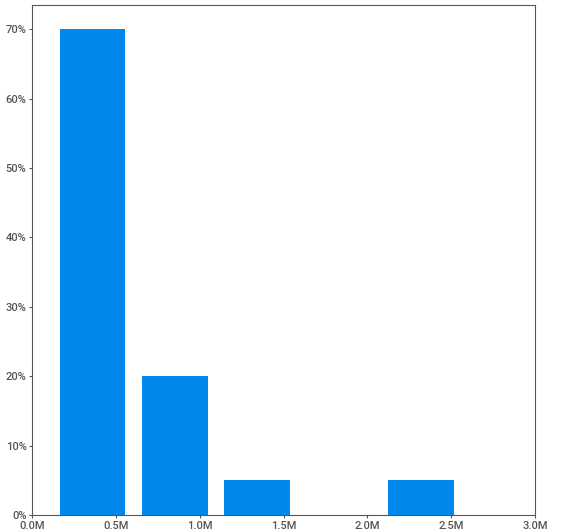
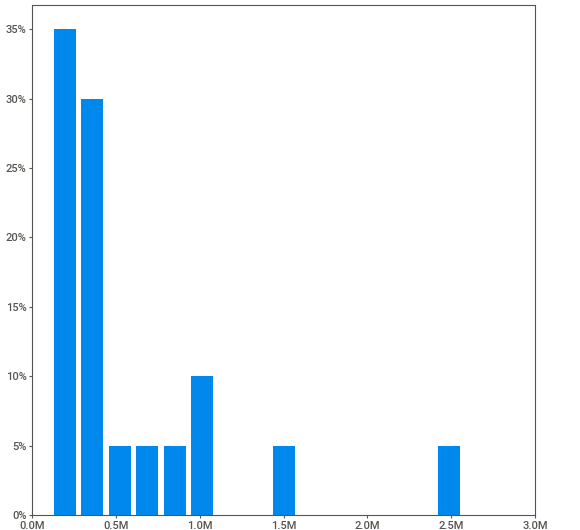
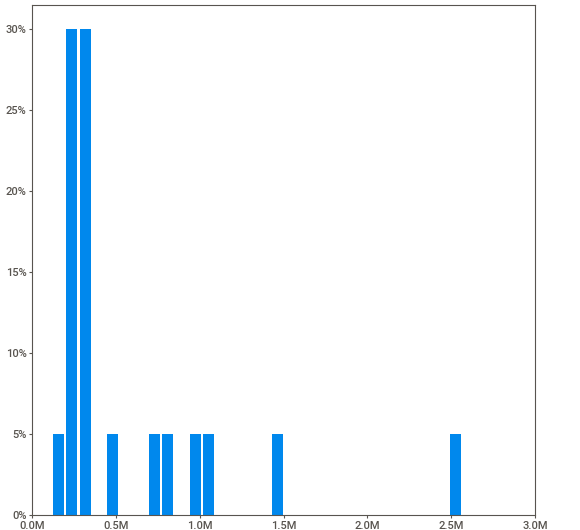
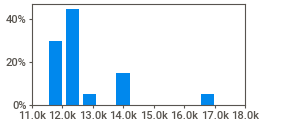
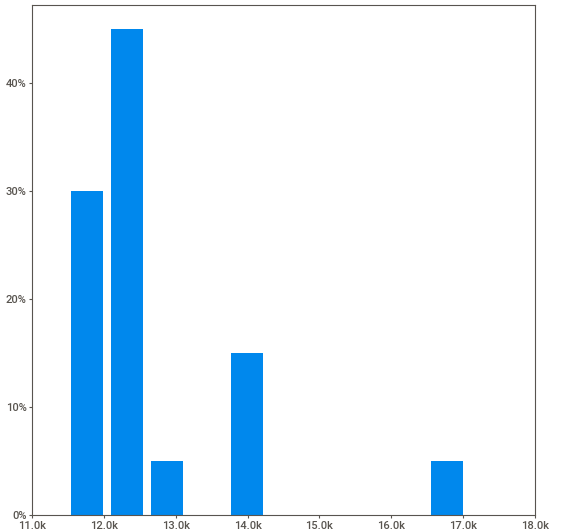
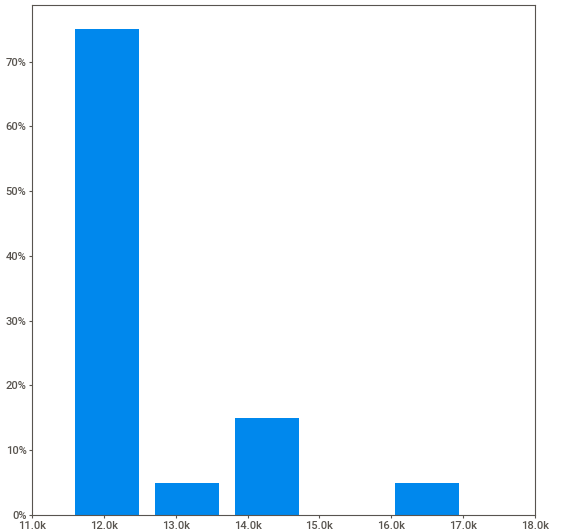
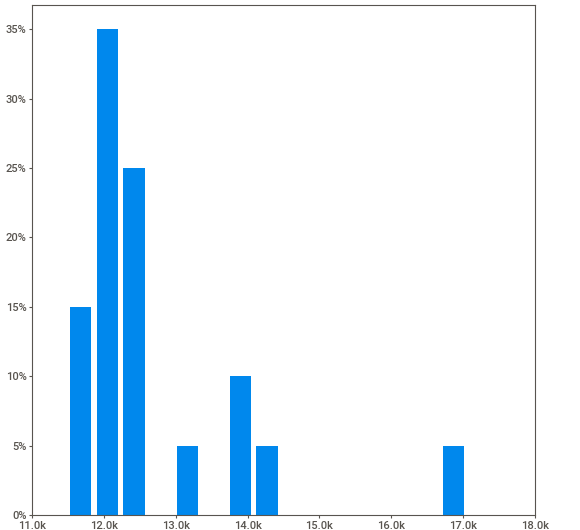
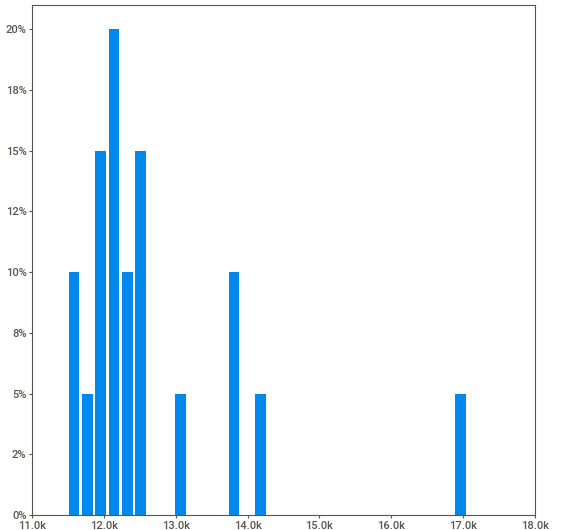
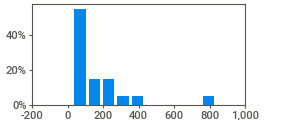
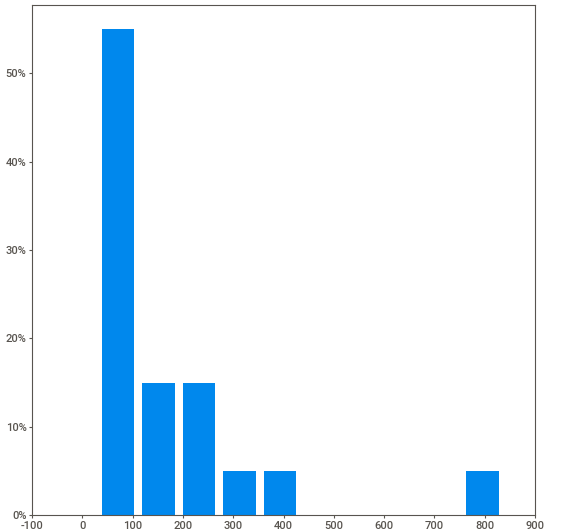
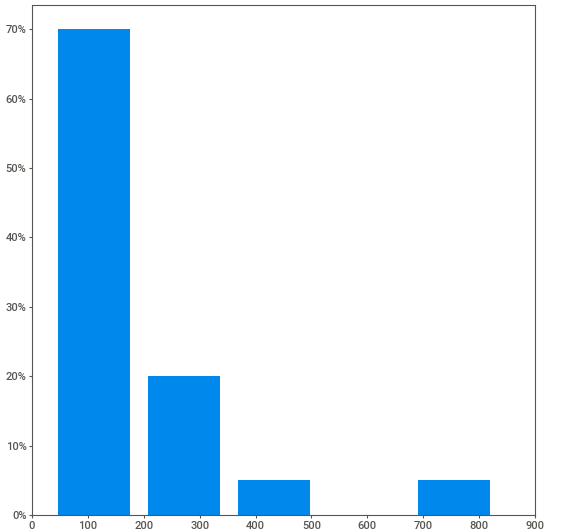
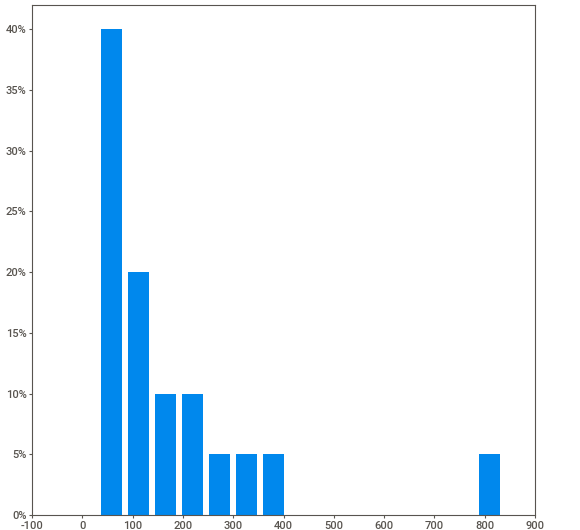
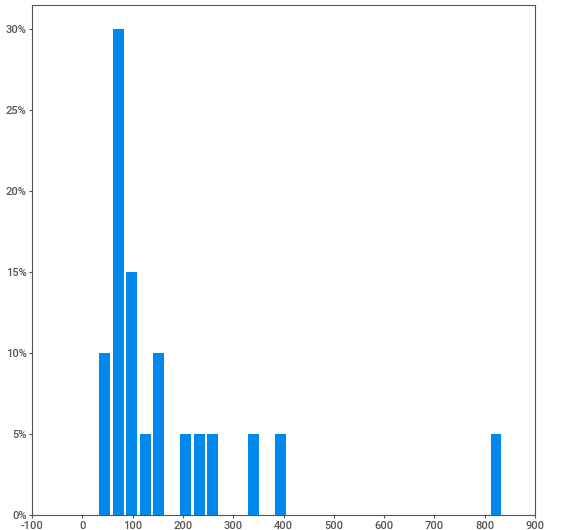
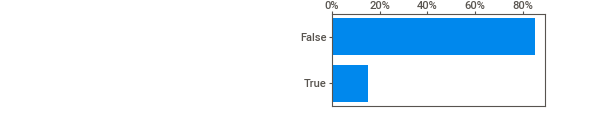
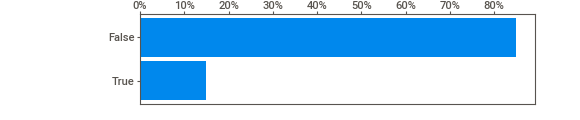
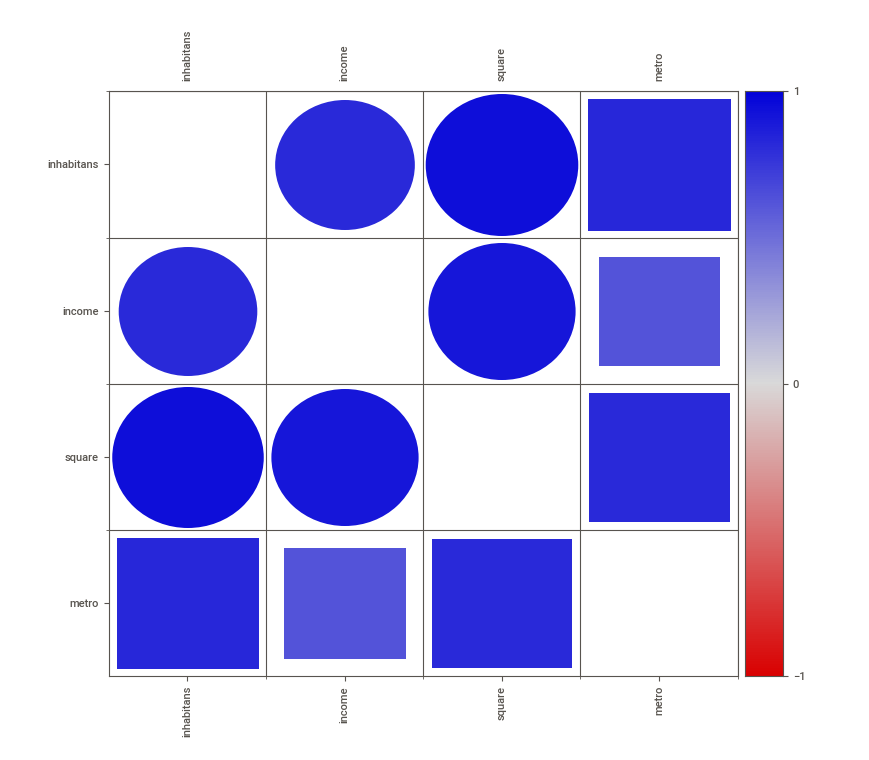
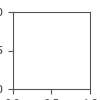

In [14]:
result = sv.analyze(df)
result.show_notebook()

**4.2 Створення звіту до таблиці за допомогою Ydata Profiling**

In [15]:
yp.ProfileReport(df)


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

**4.3 Порівняння звітів**

1. Sweetwiz не хотів встановлюватися на останню версію numpy, Ydata Profiling не хотів встановлюватися на останню версію Python. В результаті - обидва пакети встановилися і запустилися у середовищі з Python 3.10
2. Звіти обох пакетів вдалося отримати максимум у html форматі, що на мою думку, не сприйяє зручності роботи з такого виду звітами. Краще було б мати можливість опціонально отримати, скажімо, pdf формат.
3. Стосовно самих звітів, звіт Sweetwiz мені здався більш охайним за рахунок структурування звіту вкладками, а звіт Ydata Profiling, відповідно, надлишково
   перенасичений інформацією.